## AMM expected return numerical analysis

points

- arbitrager_return == -lp_return
- np.sqrt(1 + oracle_return) - 1 is convex upwards


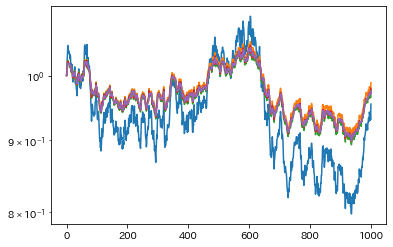

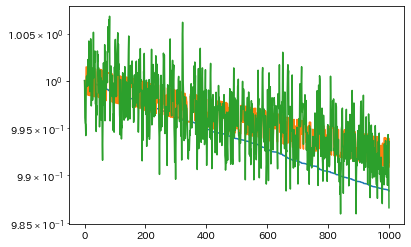

expected return assuming that only profitable arbitrage trades are done on amm
oracle 1.9773072068574037e-16
rebalance last value 0.9883592110581663
normal amm -1.1708467003843093e-05
normal amm last value 0.9768565976645195
normal amm with fee -1.3153510869905682e-05
normal amm with fee last value 0.9793444726427285
lossless amm -2.1320111944808874e-05
lossless amm last value 0.9751093391135508


In [150]:
import numpy as np
import numba
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from numba.experimental import jitclass
from scipy.optimize import minimize_scalar

@jitclass([
    ('_base', numba.float64),
    ('_quote', numba.float64),
    ('_fee_rate', numba.float64),
])
class AMM:
    def __init__(self, fee_rate):
        self._base = 0.5
        self._quote = 0.5
        self._fee_rate = fee_rate
        
    def swap(self, base_amount):
        quote_amount = self.preview_swap(base_amount)
        self._base -= base_amount
        self._quote -= quote_amount
        return quote_amount
    
    def preview_swap(self, base_amount):
        # see perpdex-contract PoolLibrary.previewSwap
        # isExactInput == false, isBaseToQuote == false base > 0
        # isExactInput == true, isBaseToQuote == true base < 0
        
        oneSubFeeRatio = 1 - self._fee_rate
        
        if base_amount < 0:
            amountSubFee = np.abs(base_amount) * oneSubFeeRatio
            output = self._quote * amountSubFee / (self._base + amountSubFee)
        else:
            if self._base - base_amount < 0:
                return np.inf
            output = self._quote * base_amount / (self._base - base_amount)
            output = output / oneSubFeeRatio    
        return -np.sign(base_amount) * output
    
    def value(self):
        return self._quote * 2

class LosslessAMM:
    def __init__(self, lossless_ratio):
        self._amm = AMM(0.0)
        self._lossless_ratio = lossless_ratio
        
    def swap(self, base_amount):
        quote_amount = self.preview_swap(base_amount)
        self._amm._base -= base_amount
        self._amm._quote -= quote_amount
        return quote_amount
    
    def preview_swap(self, base_amount):
        return self._amm.preview_swap(base_amount * self._lossless_ratio) / self._lossless_ratio
    
    def value(self):
        return self._amm.value()

def swap_arb(amm, oracle_price):
    def func(base_amount):
        quote_amount = amm.preview_swap(base_amount)
        if not np.isfinite(quote_amount):
            return 1e37
        # price is abs(detal_quote_amount / delta_base_amount)
        delta_base_amount = 1e-7
        price = np.abs((amm.preview_swap(base_amount + delta_base_amount) - quote_amount) / delta_base_amount)
        return (price - oracle_price) ** 2

    base_amount = minimize_scalar(func).x
    
    return base_amount, amm.swap(base_amount)
    
s = 0.01
n = 1000

oracle_return = lognorm.rvs(s, size=n)
# oracle_return -= lognorm.mean(s)
oracle_return -= np.mean(oracle_return) # make random walk
# oracle_return = np.exp(np.log(oracle_return) - np.mean(np.log(oracle_return)))
oracle_price = np.cumprod(np.concatenate([[0], oracle_return]) + 1)

@numba.njit
def shrink(x, a):
    return np.sign(x) * np.maximum(0, np.abs(x) - a)

def simulate(oracle_price, amm):
    assert(oracle_price[0] == 1)
    assert(amm.value() == 1)
    n = oracle_price.shape[0]
    oracle_p = oracle_price[0]
    amm_value = oracle_price * np.nan
    amm_value[0] = amm.value()
    for i in range(1, n):
        base_amount, quote_amount = swap_arb(amm, oracle_price[i])
        amm_value[i] = amm.value()
    return amm_value

def simulate_rebalance(oracle_price):
    assert(oracle_price[0] == 1)
    n = oracle_price.size
    value = oracle_price * 0.0
    value[0] = 1.0
    for i in range(1, n):
        ret = oracle_price[i] / oracle_price[i - 1] - 1
        value[i] = (1.0 + 0.5 * ret) * value[i - 1]
    return value

def calc_expected_ret(price):
    return np.mean(price[1:] / price[:-1] - 1)


rebalance_value = simulate_rebalance(oracle_price) # lossless
normal_amm_value = simulate(oracle_price, AMM(0.0))
normal_amm_with_fee_value = simulate(oracle_price, AMM(0.003))
lossless_amm_value = simulate(oracle_price, LosslessAMM(2))

plt.plot(oracle_price)
plt.plot(rebalance_value)
plt.plot(normal_amm_value)
plt.plot(normal_amm_with_fee_value)
plt.plot(lossless_amm_value)
plt.yscale('log')
plt.show()

plt.plot(normal_amm_value / rebalance_value)
plt.plot(normal_amm_with_fee_value / rebalance_value)
plt.plot(lossless_amm_value / rebalance_value)
plt.yscale('log')
plt.show()

print('expected return assuming that only profitable arbitrage trades are done on amm')
print('oracle {}'.format(calc_expected_ret(oracle_price)))
print('rebalance last value {}'.format(rebalance_value[-1]))

print('normal amm {}'.format(calc_expected_ret(normal_amm_value)))
print('normal amm last value {}'.format(normal_amm_value[-1]))
print('normal amm with fee {}'.format(calc_expected_ret(normal_amm_with_fee_value)))
print('normal amm with fee last value {}'.format(normal_amm_with_fee_value[-1]))
print('lossless amm {}'.format(calc_expected_ret(lossless_amm_value)))
print('lossless amm last value {}'.format(lossless_amm_value[-1]))
